![Top <](./images/watsonxdata.png "watsonxdata")

# Presto SQL Introduction
Watsonx.data is based on open source PrestoDB, a distributed query engine that enables querying data stored in open file formats using open table formats for optimization or performance.  This notebook will examine some of the SQL features that are available in watsonx.data. All the below tasks will be done using the Developer edition of watsonx.data.

## Connect to watsonx.data and Presto
Connectivity to Presto can be done using the following methods:

   * Command line interface(CLI)
   * Windows, Linux, OSX
   * JDBC drivers
   * watsonx.data UI

This notebook will use magic commands (`%sql`) to issue commands against the watsonx.data Presto database. You can examine the code in the presto.ipynb notebook for more details. The code is using a combination of the prestodb driver, SQLAlchemy, DBAPI, and Pandas dataframes. The next cell will load the %sql extensions. Note that this extension does not understand all of the Presto SQL dialect. It is sufficient to run the examples in the notebook.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%run '/content/drive/My Drive/Uni AI/presto.ipynb'

Presto Extensions Loaded.


The next SQL statement will connect to the watsonx.data server. These values are pre-populated and you do not need to make any changes for this to work. If you were using watsonx.data on a different server you will need to update these settings.

In [22]:
%%sql
   connect
   userid=ibmlhadmin
   password=password
   hostname=watsonxdata
   port=8443
   catalog=tpch
   schema=hive_data
   certfile =

Unknown option: 


## Overview of Schemas and Catalogs

We are going to inspect the available catalogs in the watsonx.data system. A watsonx.data catalog contains schemas and references a data source via a connector. A connector is like a driver for a database. Watsonx.data connectors are an implementation of Presto’s SPI which allows Presto to interact with a resource. There are several built-in connectors for JMX, Hive, TPCH etc., some of which you will use as part of the labs.

Display the catalogs.

In [7]:
%sql show catalogs

Unable to connect to the database.


Let's look up what schemas are available with any given catalog. We will use the TPCH catalog which is an internal PrestoDB auto-generated catalog and look at the available schemas.

In [8]:
%sql show schemas in hive_data

Unable to connect to the database.


You can connect to a specific catalog and schema and look at the tables. This requires that you update the catalog and schema that you want to view. The %sql driver uses the `USE` command:
```
%sql USE SCHEMA [schema_name]
%sql USE CATALOG [catalog_name] SCHEMA [schema_name]
```
Connect to the `tpch` catalog and set the schema to `tiny`.

In [9]:
%sql use hive_data.ontime

Unable to connect to the database.


Look at the available tables in the `TPCH` catalog under the `tiny` schema.

In [10]:
%sql show tables

Unable to connect to the database.


Inspect schema of the customer table.

In [11]:
%sql describe customer

Unable to connect to the database.


You could also use the syntax below to achieve the same result.

In [12]:
%sql show columns from customer

Unable to connect to the database.


Inspect available functions.

In [ ]:
%sql show functions like 'date%'

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Switch to a different schema. The `USE [schema]` command is used to switch to a different schema.

In [ ]:
%sql use sf1

Using schema sf1


Display the Tables in the schema.

In [ ]:
%sql show tables

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Query data from customer table.

In [ ]:
%sql select * from customer limit 5

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Gather statistics on a given table.

In [ ]:
%sql show stats for customer

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## Creating Schemas and Tables

Not all catalogs support creation of schemas - as an example, the TPCH catalog is not writeable. We will use the iceberg_data catalog for this exercise. Check to see if the workshop schema exists and then delete the tables associated with it.

In [ ]:
%%sql
use iceberg_data.none;
drop table if exists workshop.customer;
drop table if exists workshop.orders;
drop table if exists workshop.part_customer;
drop table if exists example.customer;
drop schema if exists workshop;
drop schema if exists example;

Using catalog iceberg_data with schema none
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.
Command completed.


### Creating Schemas
We are going to create a schema that points to an S3 bucket on the system.

In [ ]:
%sql CREATE SCHEMA IF NOT EXISTS workshop with (location='s3a://iceberg-bucket/')

Command completed.


Show the schemas available.

In [ ]:
%sql show schemas

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Use the workshop schema.

In [ ]:
%sql use workshop

Using schema workshop


### Creating tables

Create a new Apache Iceberg table using existing data in the sample Customer table as part of the TPCH catalog schema called TINY.

In [ ]:
%sql create table customer as select * from tpch.tiny.customer

Command completed.


Show the tables.

In [ ]:
%sql show tables

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## System Connectors
The Presto System connector provides information and metrics about the currently running Presto cluster. You can use this function to monitor the workloads on the Presto cluster using normal SQL queries.
### What queries are currently running?

In [ ]:
%sql select * from "system".runtime.queries limit 5

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

### What tasks make up a query and where is the task running?

In [ ]:
%sql select * from "system".runtime.tasks limit 5

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## Analytic Workloads

Let us start with some simple examples of running queries and analyze the execution. The `workshop` schema was created as part of an earlier step. If you have not run that SQL, the schema will not be available.

In [ ]:
%sql use iceberg_data.workshop

Using catalog iceberg_data with schema workshop


Run a simple scan query which selects customer names and market segment.

In [ ]:
%%sql
select
   name, mktsegment
from
   customer
limit 3

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

To understand the query execution plan we use the explain statement.

In [ ]:
%sql --text explain select name, mktsegment from customer

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Query Plan
- Output[name, mktsegment] => [name:varchar, mktsegment:varchar]
        Estimates: {rows: 1500 (15.95kB), cpu: 16335.00, memory: 0.00, network: 16335.00}
    - RemoteStreamingExchange[GATHER] => [name:varchar, mktsegment:v

What you see above is the hierarchy of logical operations to execute the query. Explain the query and focus on IO operations.

In [ ]:
%sql --text explain (type io) select name, mktsegment from customer

                                                                                                                                                                                                                             Query Plan
{
  "inputTableColumnInfos" : [ {
    "table" : {
      "catalog" : "iceberg_data",
      "schemaTable" : {
        "schema" : "workshop",
        "table" : "customer"
      }
    },
    "columnConstraints" : [ ]
  } ]
}


Explain physical execution plan for the query.

In [ ]:
%sql --text explain (type distributed) select name, mktsegment from customer

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Query Plan
Fragment 0 [SINGLE]
   

A fragment represents a stage of the distributed plan. The Presto scheduler schedules the execution by each stage, and stages can be run on separate instances.

Create explain statement in a visual format.

In [ ]:
x = %sql --text explain (format graphviz) select name, mktsegment from customer

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Query Plan
digraph logical_plan {
subgraph cluster_0 {
label = "SINGLE"
plannode_1[label="{Output[name, mktsegment]|Estima

Save the data into a file that can then be converted to a graphic image.

In [ ]:
explain = %sql --raw explain (format graphviz) select name, mktsegment from customer
with open("/tmp/plan.dot","w") as fd:
    fd.write(explain[0][0])

We are going to format the output from the explain statement and display it as a graphic.

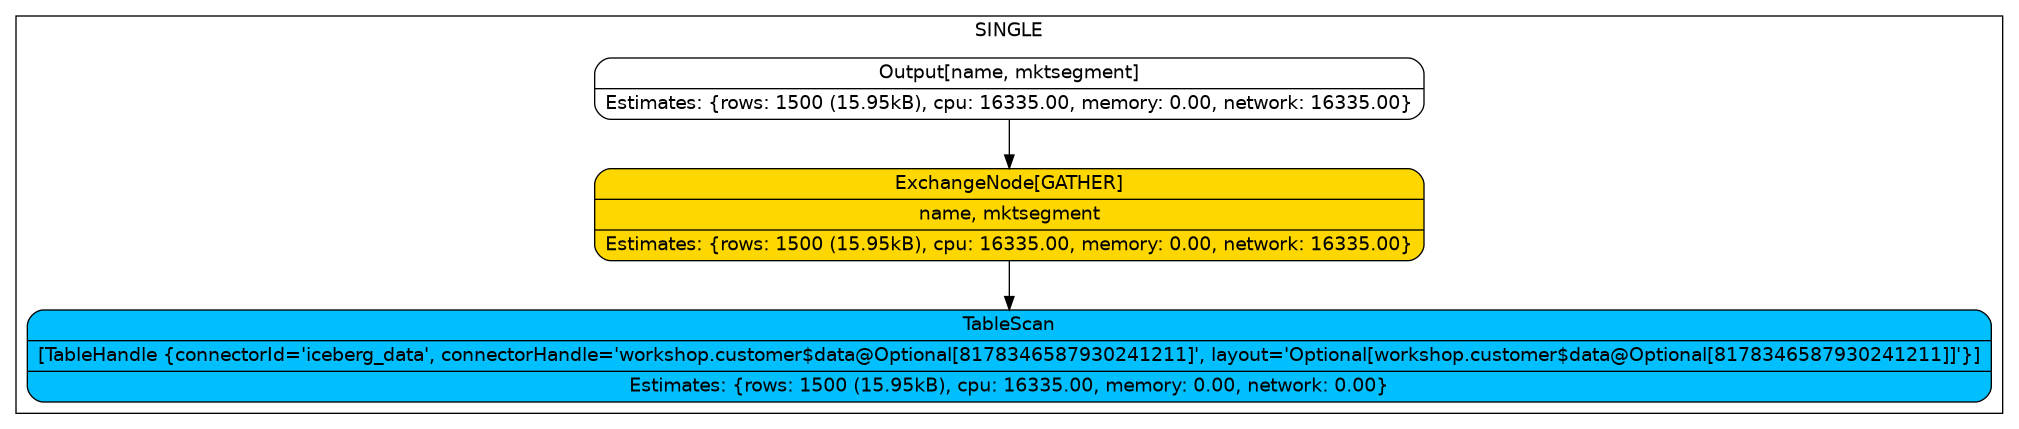

In [ ]:
from IPython.display import Image
%system dot -Tpng /tmp/plan.dot > /tmp/plan.png
Image(filename='/tmp/plan.png')

### Creating a Table with User-defined Partitions
Connect to Presto with the Workshop Schema.

In [ ]:
%sql use iceberg_data.workshop

Using catalog iceberg_data with schema workshop


Create a partitioned table, based on column `mktsegment` and copy data from `TPCH.TINY.CUSTOMER` table.

In [ ]:
%%sql
create table iceberg_data.workshop.part_customer
  with (partitioning = array['mktsegment'])
  as select * from tpch.tiny.customer

Command completed.


### Inspect object store directory/object/file structure
We can use the MinIO Call Level Interface (CLI) to view the contents of our bucket. We need to extract the userids and passwords for the MinIO service.

In [ ]:
minio_host        = "watsonxdata"
minio_port        = "9000"
minio_access_key  = None
minio_secret_key  = None

try:
    with open('/certs/passwords') as fd:
        certs = fd.readlines()
    for line in certs:
        args = line.split()
        if (len(args) >= 3):
            system   = args[0].strip()
            user     = args[1].strip()
            password = args[2].strip()
            if (system == "Minio"):
                minio_access_key = user
                minio_secret_key = password
            else:
                pass
except Error as e:
    print("Certificate file with passwords could not be found")

### Minio System Alias
Before running any commands against the MinIO server, an alias needs to be created that includes the access and secret key.

In [ ]:
%system mc alias set watsonxdata http://{minio_host}:{minio_port} {minio_access_key} {minio_secret_key}

['Added `watsonxdata` successfully.']

### List Buckets
The `mc` command provides us with a number of commands that allows us to manage buckets and files within them. The following command checks to see what buckets are available in the system. We want to make sure that the `iceberg-bucket` exists.

In [ ]:
%system mc ls tree watsonxdata

['[2024-02-29 13:52:42 EST]     0B hive-bucket/',
 '[2024-02-29 13:52:41 EST]     0B iceberg-bucket/',
 '[2024-02-29 13:52:42 EST]     0B wxd-milvus/',
 '[2024-02-29 13:52:42 EST]     0B wxd-system/']

At this point we can check the file tree for the `iceberg-bucket`.

In [ ]:
%system mc ls tree watsonxdata/iceberg-bucket

['[2024-04-19 20:12:09 EDT]     0B customer/',
 '[2024-04-19 20:12:09 EDT]     0B part_customer/']

Examining the part_customer, you will notice is the data is split into multiple parquet files stored across multiple directories - a single directory for each unique value of the partition key.

In [ ]:
%system mc ls tree watsonxdata/iceberg-bucket/part_customer/data

['[2024-04-19 20:12:09 EDT]     0B mktsegment=AUTOMOBILE/',
 '[2024-04-19 20:12:09 EDT]     0B mktsegment=BUILDING/',
 '[2024-04-19 20:12:09 EDT]     0B mktsegment=FURNITURE/',
 '[2024-04-19 20:12:09 EDT]     0B mktsegment=HOUSEHOLD/',
 '[2024-04-19 20:12:09 EDT]     0B mktsegment=MACHINERY/']

### Predicate query to utilize partitions
Now that have created a partitioned table, we will execute a SQL statement that will make use of this fact.

In [ ]:
%%sql
SELECT *
  FROM  iceberg_data."workshop".part_customer
  WHERE mktsegment='MACHINERY'

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Due to the partitioning of this table by `mktsegment`, it will completely skip scanning a large percentage of the objects in the object store. We run an explain against this query using the following command.

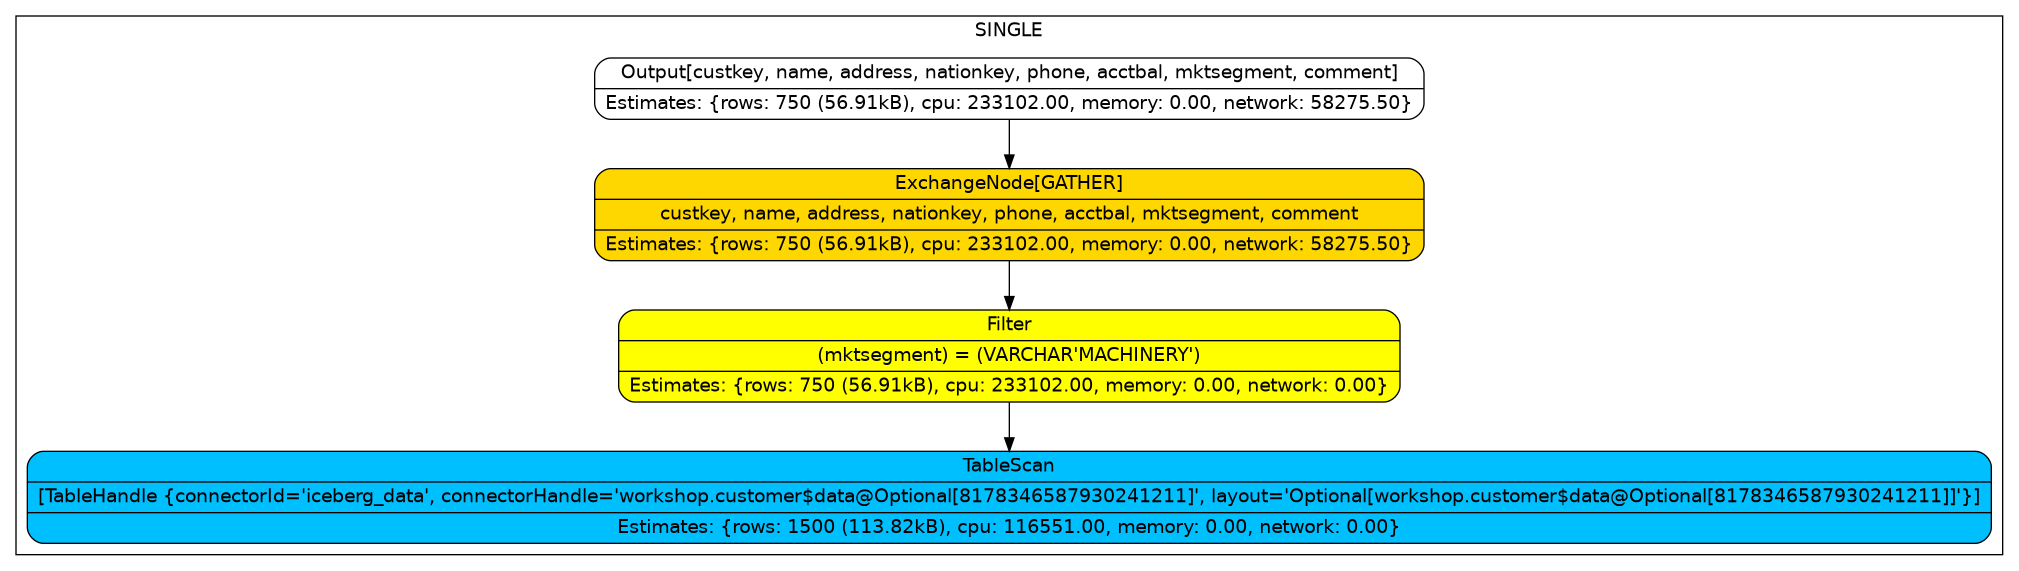

In [ ]:
explain = \
   %sql --raw explain (format graphviz) \
       select * from iceberg_data."workshop".customer \
       where mktsegment='MACHINERY'
with open("/tmp/plan.dot","w") as fd:
    fd.write(explain[0][0])
%system dot -Tpng /tmp/plan.dot > /tmp/plan.png
Image(filename='/tmp/plan.png')

## Joins and Aggregations
This section will create an orders table to test joins and aggregations. Connect to the workshop schema.

In [ ]:
%sql use iceberg_data.workshop

Using catalog iceberg_data with schema workshop


Create the Orders Table.

In [ ]:
%%sql
create table iceberg_data.workshop.orders as
  select * from tpch.tiny.orders

Command completed.


Check that the table exists.

In [ ]:
%sql show tables in iceberg_data.workshop

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Use a Windowing function.

In [ ]:
%%sql
SELECT
   orderkey, clerk, totalprice,
   rank() OVER (PARTITION BY clerk ORDER BY totalprice DESC) AS rnk
FROM
   orders
ORDER BY
   clerk, rnk

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## Prepared statements

Save a query as a prepared statement.

In [ ]:
%%sql
prepare
   customer_by_segment
from
   select * from customer where mktsegment=?

Command completed.


Execute prepared statement using parameters.

In [ ]:
%sql execute customer_by_segment using 'FURNITURE'

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## Advanced Functions

Watsonx.data supports several types of functions including:

   * Mathematical functions
   * Conversion functions
   * String functions
   * Regular expression functions
   * Window functions
   * URL functions
   * Geospatial functions

For a complete list see - [https://prestodb.io/docs/current/functions.html](https://prestodb.io/docs/current/functions.html). We will look at using a few simple examples as part of this notebook.

In [ ]:
%sql use iceberg_data.workshop

Using catalog iceberg_data with schema workshop


### Concatenation of one or more string/varchar values
Note: We are using a combination of the “concat” string function and the “cast” conversion function as part of this query.

In [ ]:
%%sql
select
   concat(cast(custkey as varchar),'--',name)
from
   customer
limit 2

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

### Date functions
Date functions can be used as part of the projected columns or in the predicate/where clause.
Select orders from the last 2 days.

In [ ]:
%%sql
select
   orderdate
from
   orders
where
   orderdate >  date '1998-08-02' - interval '2' day

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Number of orders by year.

In [ ]:
%%sql
select
   distinct year(orderdate), count(orderkey)
from
   orders
group by
   year(orderdate);

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

### Geospatial functions

There are 3 basic geometries, then some complex geometries. The basic geometries include:

   * Points
   * Lines
   * Polygons

#### Points

You could use [https://www.latlong.net](https://www.latlong.net) to get the longitude/latitude given any address.

In [ ]:
%%sql --text
select
   ST_Point(-121.748360,37.195840) as SVL,
   ST_Point(-122.378952, 37.621311) as SFO

                        SVL                           SFO
POINT (-121.74836 37.19584) POINT (-122.378952 37.621311)


#### Lines

You could use [https://www.latlong.net](https://www.latlong.net) to get the longitude/latitude for 2 points and then create a straight line from it. Below is just a small stretch of the road leading to IBM SVL campus.

In [ ]:
%%sql --text
select
   ST_LineFromText('LINESTRING (-121.74294303079807 37.19665657093434, -121.73659072815602 37.20102399761407)')

                                                                                    _col0
LINESTRING (-121.74294303079807 37.19665657093434, -121.73659072815602 37.20102399761407)


#### Polygons

You could use [https://geojson.io/#map=16.39/37.196336/-121.746303](https://geojson.io/#map=16.39/37.196336/-121.746303) to click around and generate the coordinates for a polygon of any shape. The following is a polygon of the IBM Silicon Valley campus.

In [ ]:
%%sql --text
select ST_Polygon('POLYGON (
   (-121.74418635253568 37.196001834113844,
    -121.74499684288966 37.19668005184322,
    -121.74584008032835 37.19707784979194,
    -121.74629035274705 37.197645197338105,
    -121.74672425162339 37.198186455965086,
    -121.74705172247337 37.19828427337538,
    -121.74760023614738 37.19827775221884,
    -121.74848440744239 37.19836252721197,
    -121.74932764488139 37.19789300297414,
    -121.75039192514376 37.19746260319114,
    -121.75130884352407 37.19721479614175,
    -121.75195559845278 37.1963670290329,
    -121.75198015876644 37.19555185937345,
    -121.7508585711051 37.19458016564036,
    -121.74940132582242 37.19447582194559,
    -121.74841891327239 37.1942866986312,
    -121.7474446874937 37.193556286900346,
    -121.74418635253568 37.196001834113844))')

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    _col0
POLYGON ((-121.74418635253568 37.196001834113844, -121.74499684288966 37.19668005184322, -121.74584008032835 37.19707784979194, -121.74629035274705 37.197645197338105, -121.74672425162339 37.198186455965086, -121.74705172247337 37.19828427337538, -121.74760023614738 37.19827775221884, 

So now that we have 3 basic geometries Point, Line and Polygon we can perform different operations on spatial data including:
* Distance between 2 points
* Point in polygon
* Intersection of line and polygon
#### Distance between SFO airport and IBM SVL

We can now use geospatial functions in a nested way to find the distance between 2 points.

In [ ]:
%%sql
select
   ST_Distance(to_spherical_geography(ST_Point(-122.378952, 37.621311)),
   to_spherical_geography(ST_Point(-121.748360,37.195840)))*0.000621371 as distance_in_miles;

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

## Time Travel
Time travel allows you change the view of the data to a previous time. This is not the same as an `AS OF` query commonly used in SQL. The data is rolled back to a prior time. The first step is to create a new bucket that we will use for our example.

Now we will create a new schema in the iceberg_data catalog that points to this empty bucket. Note how the use statement here uses `None` as the schema since we don't know what we are going to connect to yet.

In [ ]:
%sql use iceberg_data.none
%sql drop table if exists example.customer
%sql drop schema if exists example

Using catalog iceberg_data with schema none
Command completed.
Command completed.


Next we create the schema that we are going to use.

In [ ]:
%sql CREATE SCHEMA IF NOT EXISTS iceberg_data.example with (location='s3a://iceberg-bucket/sample')

Command completed.


In [ ]:
%sql show schemas in iceberg_data

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

In this step we will create the customer table based on the TPCH table of the same name. First step to switch to our schema and then create the customer table.

In [ ]:
%sql use iceberg_data.example
%sql create table example.customer as select * from tpch.tiny.customer
%sql select * from example.customer limit 10

Using catalog iceberg_data with schema example
Command completed.


DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Let us look at the snapshots available for the customer table in the workshop schema. We currently have just 1 snapshot. First make sure you are in the proper directory.

Check current snapshots – STARTING STATE.

In [ ]:
%%sql
SELECT
   *
FROM
   iceberg_data.example."customer$snapshots"
ORDER BY
   committed_at

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Capture the first snapshot ID returned by the SQL statement. You will need this value when you run the rollback command.

In [ ]:
%sql SELECT snapshot_id FROM iceberg_data.example."customer$snapshots" ORDER BY committed_at;

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

For convenience, we are going to get this value and place it into a Python variable for use in another statement.

In [ ]:
snapshot_id = %sql --raw SELECT snapshot_id FROM iceberg_data.example."customer$snapshots" ORDER BY committed_at
snapshot_id = snapshot_id[0][0]
print(snapshot_id)

7247054150428701381


Remember that number that was returned with the query above. Insert the following record to change the customer table in the workshop schema.

In [ ]:
%%sql
insert into example.customer
  values(1501,'Deepak','IBM SVL',16,'123-212-3455',
         123,'AUTOMOBILE','Testing snapshots')

Command completed.


Let us look at the snapshots available for the customer table in the workshop schema. You should have 2 snapshots.

In [ ]:
%%sql
SELECT
   *
FROM
   iceberg_data.example."customer$snapshots"
ORDER BY
   committed_at

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Querying the customer table in the workshop schema, we can see the record inserted with name=’Deepak’.

In [ ]:
%sql select * from example.customer where name='Deepak'

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

We realize that we don’t want the recent updates or just want to see what the data was at any point in time to respond to regulatory requirements. We will leverage the out-of-box system function `rollback_to_snapshot` to rollback to an older snapshot. The syntax for this function is:
```sql
CALL iceberg_data.system.rollback_to_snapshot('workshop','customer',x)
```

The "x" would get replaced with the `snapshot_id` number that was found in the earlier query. When using the `%sql` command, you can use the "{value}" syntax to substitute values into the string.

In [ ]:
%sql CALL iceberg_data.system.rollback_to_snapshot('example','customer',{snapshot_id})

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

Querying the customer table in the workshop schema, we cannot see the record inserted with name=’Deepak’.

In [ ]:
%sql select * from example.customer where name='Deepak'

No rows found.


#### Credits: IBM 2024, George Baklarz [baklarz@ca.ibm.com]